In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Python Spark SQL basic example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pyspark.sql.functions import col, countDistinct, trim, length, to_date, year, month, when
from pyspark.sql import functions as F 

In [7]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [27]:
#plt.rcParams['font.family'] = 'Serif'
plt.style.use('bmh')

In [4]:
df_lighter_books = spark.read.json("lighter_books.json")
df_lighter_authors = spark.read.json("lighter_authors.json")

In [5]:
df_lighter_books.createOrReplaceTempView("lighter_books")
df_lighter_authors.createOrReplaceTempView("lighter_authors")

In [6]:
df_lighter_books = df_lighter_books.dropDuplicates()
df_lighter_authors = df_lighter_authors.dropDuplicates()

# [RQ1] Exploratory Data Analysis (EDA) 
We have two main files in which our data are saved, "lighter_authors.json" and "lighter_books.json". 
- To begin the exploratory analysis we start by looking at the first few rows of our datasets. We created the count_columns_type function in order to see how many columns in the dataset contain numeric, categorical, or other variables. We also printed out how many rows each dataset has. 
Books_lighter has 26 columns and a total of 7027431 rows while Authors_lighter has 12 columns and 351767 rows. it is also useful to print the list with all the columns of the datasets.
- 
- 

In [9]:
# Function to obtain the type of the columns
def count_columns_type(data):
    categorial = 0
    numeric = 0
    other = 0
    from pyspark.sql.types import StringType, DoubleType, LongType
    for col in data.columns:
        c_type = data.schema[col].dataType
        #print(c_type)
        if isinstance(c_type, StringType):
            categorial += 1
            
        elif isinstance(c_type, LongType) or isinstance(c_type,DoubleType):
            numeric += 1
        else:
            other += 1
    print("The number of categorial columns is: ", categorial)
    print("The number of numeric columns is: ", numeric)
    print("The number of other types of columns is: ", other)

In [8]:
books_5 = spark.sql("SELECT (*) FROM lighter_books LIMIT 5").toPandas()
display(books_5)
print("The total number of columns is:", len(df_lighter_books.columns))
count_columns_type(df_lighter_books)
count_books = spark.sql("SELECT COUNT(*) FROM lighter_books").toPandas()
print("The number of rows in the books file is:" , count_books.iloc[0,0])

,asin,author_id,author_name,authors,average_rating,description,edition_information,format,id,image_url,...,publisher,rating_dist,ratings_count,series_id,series_name,series_position,shelves,text_reviews_count,title,work_id
0,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.50,There is a door at the end of a silent corrido...,US Edition,Paperback,2,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1674064|4:664833|3:231195|2:41699|1:16215|to...,2628006,45175,Harry Potter,5,"[(324191, to-read), (52675, currently-reading)...",44716,Harry Potter and the Order of the Phoenix (Har...,2809203
1,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.48,Harry Potter's life is miserable. His parents ...,Library Edition,Hardcover,3,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc,5:4801606|4:1681521|3:623286|2:145898|1:125040...,7377351,45175,Harry Potter,1,"[(63540, fantasy), (57260, favorites), (20889,...",116930,Harry Potter and the Sorcerer's Stone (Harry P...,4640799
2,,1077326,J.K. Rowling,None,4.43,The Dursleys were so mean and hideous that sum...,,Hardcover,4,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1690166|4:781011|3:313727|2:54687|1:15453|to...,2855044,45175,Harry Potter,2,"[(282341, to-read), (67110, currently-reading)...",55286,Harry Potter and the Chamber of Secrets (Harry...,6231171
3,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.57,"For twelve long years, the dread fortress of A...",,Mass Market Paperback,5,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1994597|4:696545|3:212678|2:28915|1:13959|to...,2946694,45175,Harry Potter,3,"[(292815, to-read), (52580, fantasy), (49479, ...",58023,Harry Potter and the Prisoner of Azkaban (Harr...,2402163
4,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.56,Harry Potter is midway through his training as...,First Scholastic Trade Paperback Edition,Paperback,6,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1808039|4:663849|3:193604|2:27759|1:12425|to...,2705676,45175,Harry Potter,4,"[(287086, to-read), (60111, currently-reading)...",48637,Harry Potter and the Goblet of Fire (Harry Pot...,3046572


The total number of columns is: 26
The number of categorial columns is:  17
The number of numeric columns is:  7
The number of other types of columns is:  2
The number of rows in the books file is: 7027431


In [9]:
authors_5 = spark.sql("SELECT (*) FROM lighter_authors LIMIT 5").toPandas()
display(authors_5)
print("The total number of columns is:", len(df_lighter_authors.columns))
count_columns_type(df_lighter_authors)
count_authors = spark.sql("SELECT COUNT(*) FROM lighter_authors").toPandas()
print("The number of rows in the authors file is:" , count_authors.iloc[0,0])

,about,average_rating,book_ids,fans_count,gender,id,image_url,name,ratings_count,text_reviews_count,work_ids,works_count
0,"Douglas Noël Adams was an English author, comi...",4.19,"[386162, 13, 8695, 8694, 6091075, 365, 569429,...",19826,male,4,https://images.gr-assets.com/authors/159137433...,Douglas Adams,2862064,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...",106
1,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",4.02,"[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",16144,male,7,https://images.gr-assets.com/authors/157859752...,Bill Bryson,1417316,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...",75
2,"Jude Fisher is the pseudonym for <a href=""http...",4.53,"[349254, 15222, 14833682, 15221, 18126815, 152...",60,female,10,https://images.gr-assets.com/authors/141145711...,Jude Fisher,56159,352,"[17150, 808427, 20487307, 90550, 25460625, 171...",14
3,James Hamilton-Paterson's work has been transl...,3.79,"[40, 9416484, 12482, 3753106, 26889789, 104764...",72,male,12,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson,3302,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...",45
4,Mark Andrew Watson (born 13 February 1980) is ...,3.60,"[8466327, 15739968, 22756778, 51026133, 260451...",179,male,14,https://images.gr-assets.com/authors/133175379...,Mark Watson,7979,772,"[13330815, 19109351, 42306244, 72694240, 26291...",61


The total number of columns is: 12
The number of categorial columns is:  4
The number of numeric columns is:  6
The number of other types of columns is:  2
The number of rows in the authors file is: 351767


In [10]:
df_lighter_books.columns

['asin',
 'author_id',
 'author_name',
 'authors',
 'average_rating',
 'description',
 'edition_information',
 'format',
 'id',
 'image_url',
 'isbn',
 'isbn13',
 'language',
 'num_pages',
 'original_publication_date',
 'publication_date',
 'publisher',
 'rating_dist',
 'ratings_count',
 'series_id',
 'series_name',
 'series_position',
 'shelves',
 'text_reviews_count',
 'title',
 'work_id']

In [11]:
df_lighter_authors.columns

['about',
 'average_rating',
 'book_ids',
 'fans_count',
 'gender',
 'id',
 'image_url',
 'name',
 'ratings_count',
 'text_reviews_count',
 'work_ids',
 'works_count']

In [20]:
# Descriptive statistics for numeric variables
statistics_num_var = df_lighter_books.select("average_rating", "edition_information", "ratings_count", "text_reviews_count").describe().toPandas()

In [10]:
df_lighter_books = df_lighter_books.filter(trim(col("format")) != "")
df_lighter_books = df_lighter_books.filter(trim(col("publisher")) != "")
df_lighter_books = df_lighter_books.dropna(subset=["format","publisher"])

In [11]:
# For categorical variables we can make frequency tables for example abot the format of the books
formats = spark.sql("SELECT format, COUNT(*) FROM lighter_books GROUP BY format ORDER BY COUNT(*) DESC").toPandas()
# The same can be done for the publisher
publishers = spark.sql("SELECT publisher, COUNT(*) FROM lighter_books GROUP BY publisher ORDER BY COUNT(*) DESC").toPandas()


In [12]:
formats.head(5)

,format,count(1)
0,Paperback,2247613
1,,2240100
2,Hardcover,979886
3,ebook,900712
4,Kindle Edition,154234


In [13]:
publishers.head(5)

,publisher,count(1)
0,,2165557
1,Book on Demand Ltd.,108862
2,Createspace Independent Publishing Platform,89311
3,Smashwords Edition,79131
4,Turtleback Books,58760


In [26]:
df_lighter_authors = df_lighter_authors.filter(trim(col("gender")) != "")
df_lighter_authors = df_lighter_authors.dropna(subset=["gender"])


In [15]:
df_lighter_authors = df_lighter_authors.withColumn("gender_standard", when(col("gender").isin("non-binary", "Nonbinary", "Non-binary", "nonbinary"), "Non-binary").otherwise(col("gender")))

In [39]:
df_lighter_authors.show()

+--------------------+--------------+--------------------+----------+------+------+--------------------+--------------------+-------------+------------------+--------------------+-----------+---------------+
|               about|average_rating|            book_ids|fans_count|gender|    id|           image_url|                name|ratings_count|text_reviews_count|            work_ids|works_count|gender_standard|
+--------------------+--------------+--------------------+----------+------+------+--------------------+--------------------+-------------+------------------+--------------------+-----------+---------------+
|American ambassad...|          3.06|[290618, 735481, ...|         0|  male| 84378|https://s.gr-asse...|Thomas Patrick Me...|           18|                 5|[281951, 721665, ...|          9|           male|
|Robert Mailer And...|          3.28|[54461, 53113691,...|         4|  male| 30765|https://s.gr-asse...|Robert Mailer And...|          472|                81|[53102, 73

In [16]:
df_lighter_authors.createOrReplaceTempView("lighter_authors") #needed again because the standardized gender

In [17]:
# About the authors we can do a plot to see the distribution of the gender
gender_authors = spark.sql("SELECT gender_standard, COUNT(*) FROM lighter_authors GROUP BY gender_standard ORDER BY count(*) DESC").toPandas()

In [18]:
gender_authors.head(5)

,gender_standard,count(1)
0,male,138179
1,female,109878
2,,103377
3,Non-binary,95
4,genderqueer,28


<BarContainer object of 5 artists>

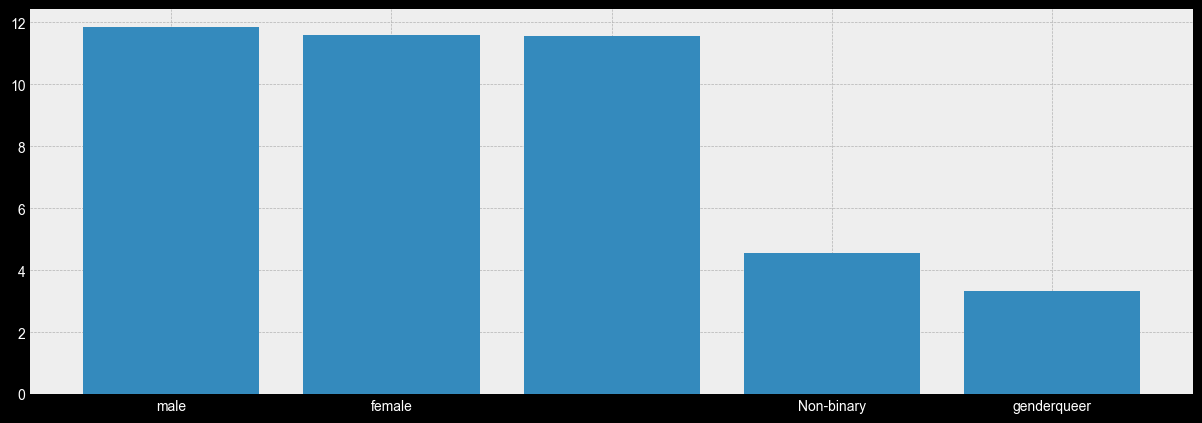

In [28]:
plt.figure(figsize=(15,5))
plt.bar(gender_authors["gender_standard"].head(5),np.log(gender_authors["count(1)"].head(5))) #logaritmic scale to make the differences visible

# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:
- Plot the number of books for each author in descending order.

In [8]:
# Cleaning a bit the data
df_lighter_books = df_lighter_books.filter(trim(col("author_name")) != "") # removes rows with empty author_name
df_lighter_books = df_lighter_books.dropna(subset=["author_name"])

In [9]:
freq_authors = df_lighter_books.groupBy("author_name").count().toPandas() #6 minutes to run

In [15]:
#The are 259788 rows in freq_authors and for plotting the number of books for each author in descending order we have done 2 attempts:
freq_authors.head(5)

,author_name,count
0,Walter F. Edwards,17
1,Robert Harris,4
2,Johannes Brahms,590
3,Giorgio Vasari,255
4,Derrick Frances,98


### First attempt: sampling only one author for each value of book count

In [10]:
freq_authors.sort_values(by="count" ,ascending=False).head(20)
# We see that some of them are not properly authors like "Anonymous","Unknown","NOT A BOOK" and so we eliminate them
freq_authors = freq_authors.drop([66257,96201,127622])
#freq_authors = freq_authors.drop([0,96201])
#freq_authors = freq_authors.drop([0,66257])

freq_authors["count"].value_counts() #There are way to many authors to be seen in a plot, a possible strategy to show the distribution of the books is to
# sample one author for each value, we will have 1303 bars, maybe we should do 10 plots 
freq_authors_sample = freq_authors.groupby("count").apply(lambda group: group.sample(1)).reset_index(drop=True).sort_values(by="count", ascending=False)
freq_authors_sample

,author_name,count
1302,Jesse Russell,90086
1301,Source Wikipedia,54296
1300,Various,33581
1299,Philip M. Parker,27634
1298,Books LLC,22414
...,...,...
4,Giuliano Baioni,5
3,Leonie Albani-Tremaine,4
2,Goldie Millar,3
1,Patrick Timm,2


In [11]:
def division_data(data,n):
    interval_len = len(data) // n
    divisions = []
    start = 0
    for i in range(n):
        end = start + interval_len
        divisions.append(data.iloc[start:end])
        start = end
    # if there are any rows left, concat them with the last chunk
    if start < len(data):
        divisions[-1] = pd.concat([divisions[-1], data.iloc[start:]])
    return divisions

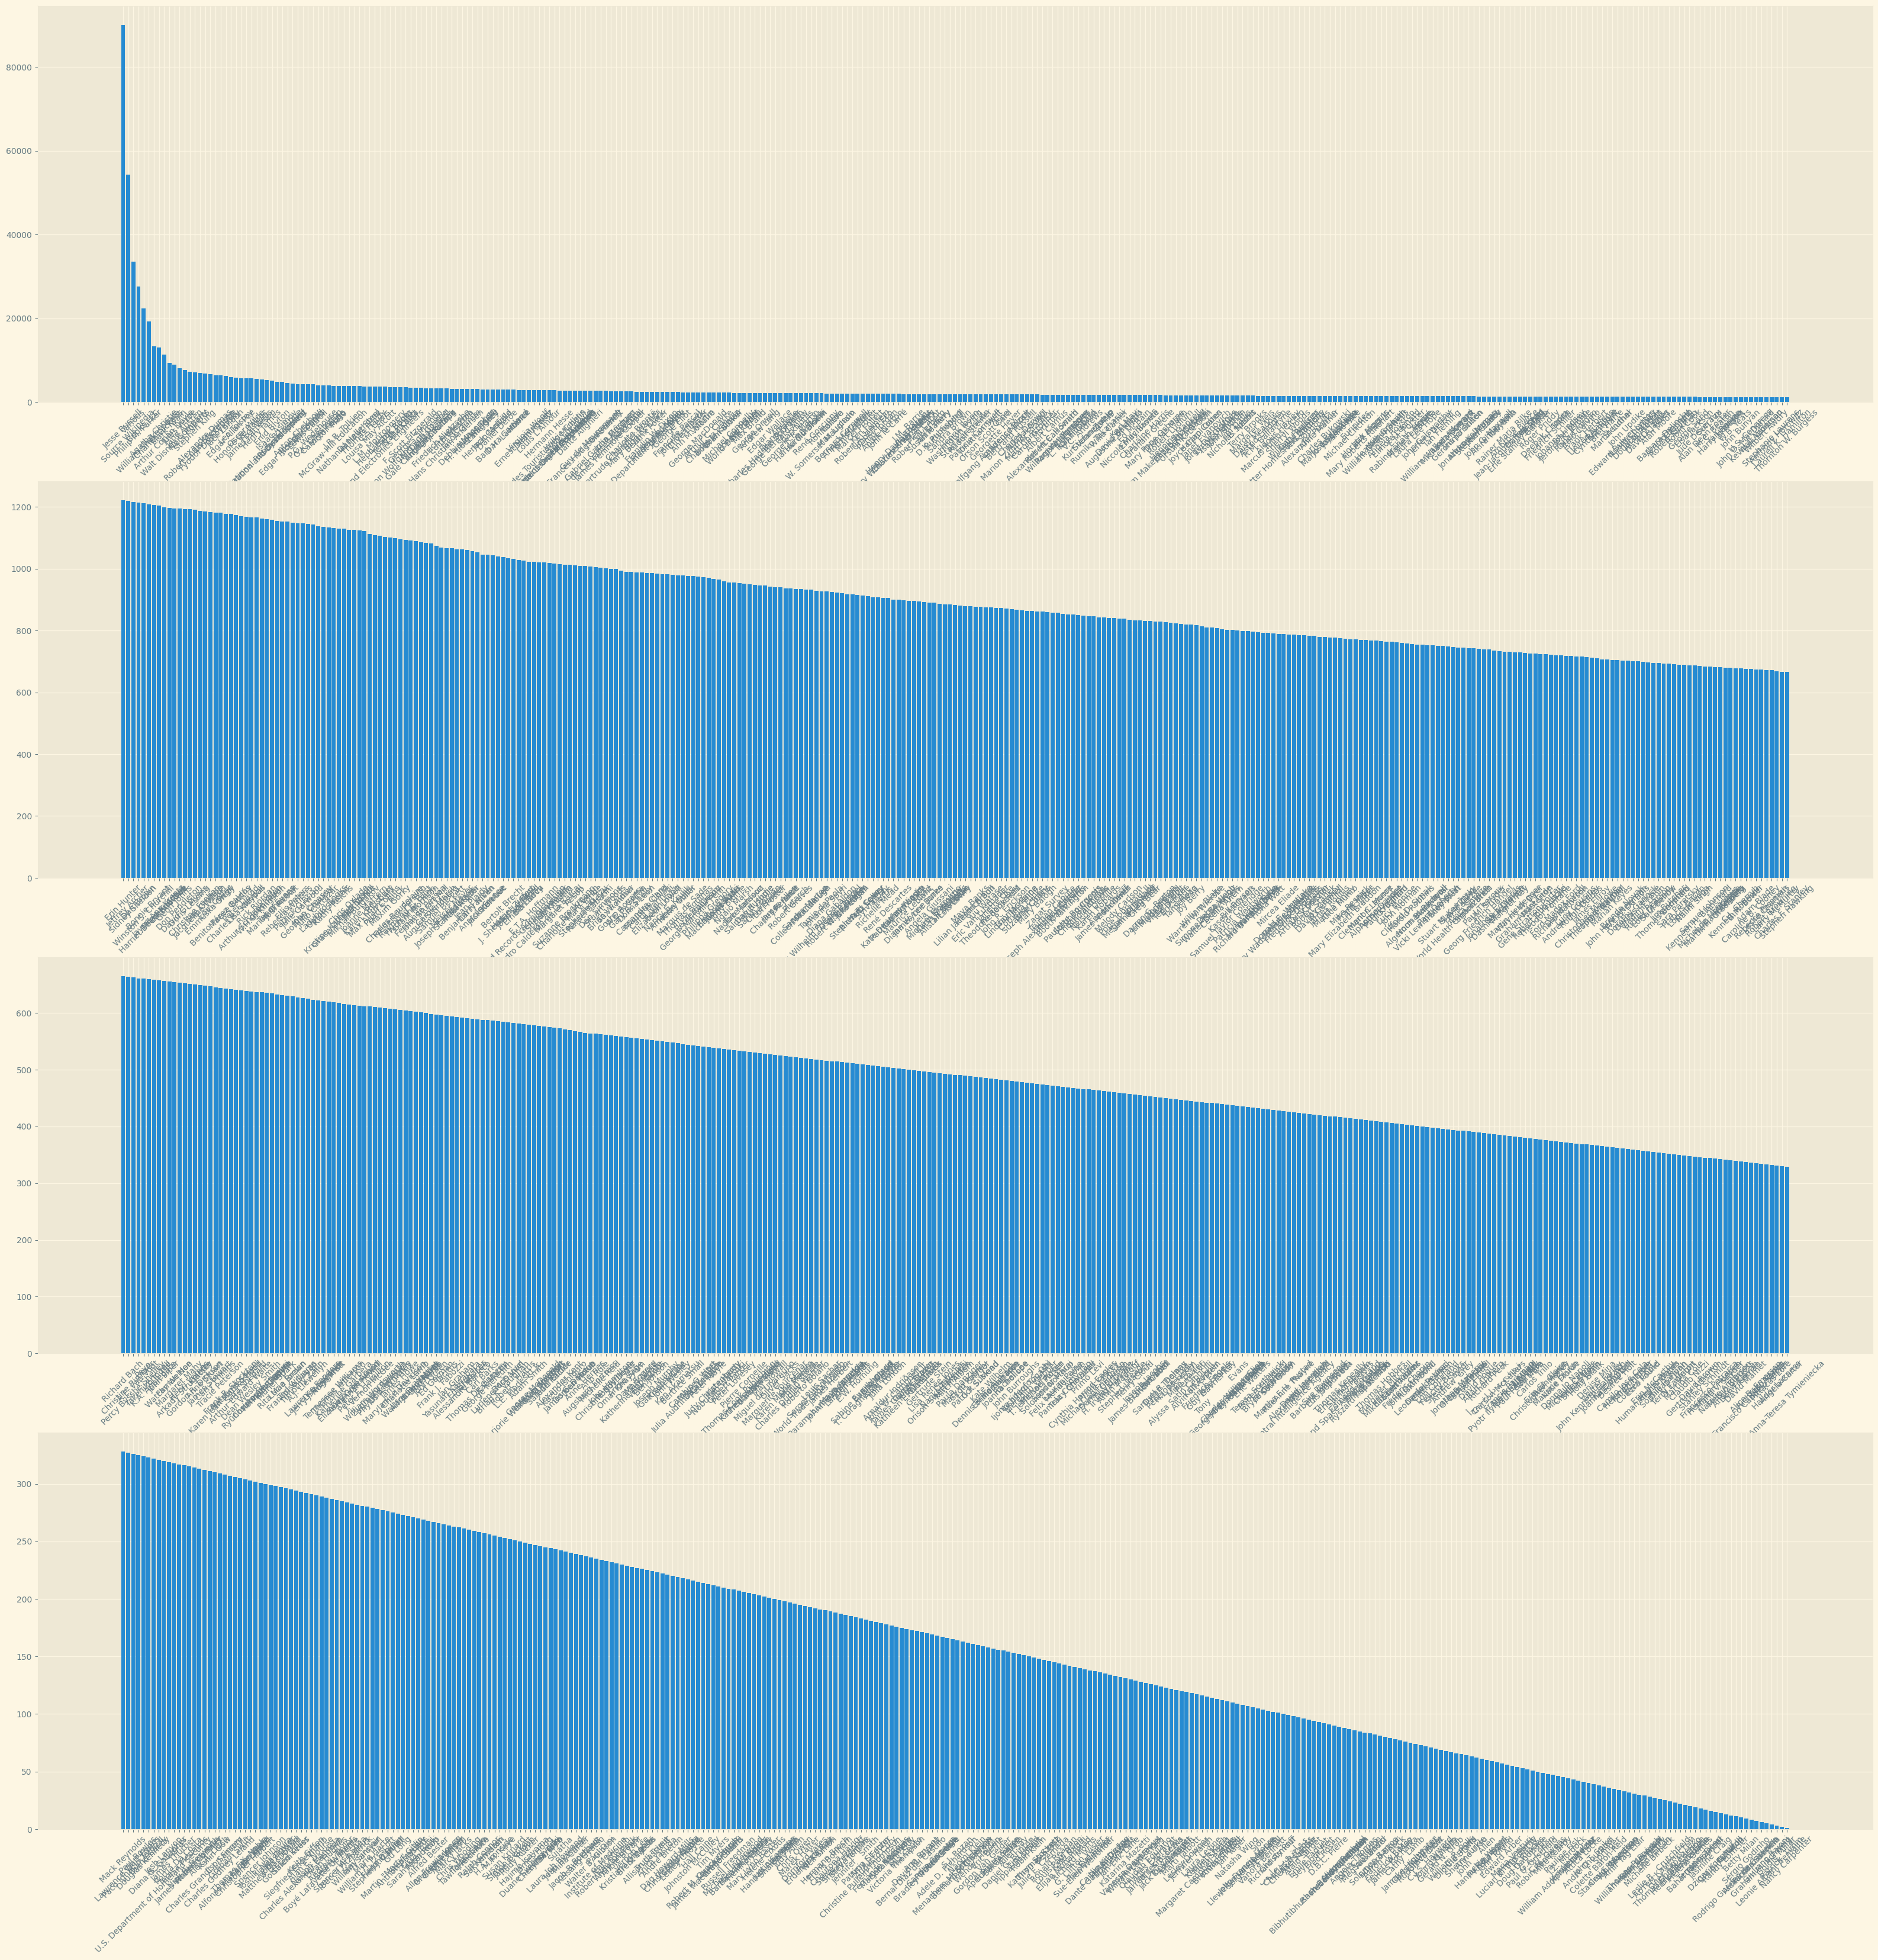

In [12]:
divised = division_data(freq_authors_sample,4)
fig, axes = plt.subplots(len(divised), 1, figsize=(40, 40))
for i,data in enumerate(divised):
    ax = axes[i]
    #ax.xticks(rotation=45, fontsize = 4)
    ax.bar(data["author_name"],data["count"])
    ax.tick_params(axis='x', labelrotation=45)

### Second attempt: draw a sample of n = 30 and plot the results

In [13]:
freq_authors_sample_2 = freq_authors_sample.sample(30).sort_values(by="count", ascending=False)

<BarContainer object of 30 artists>

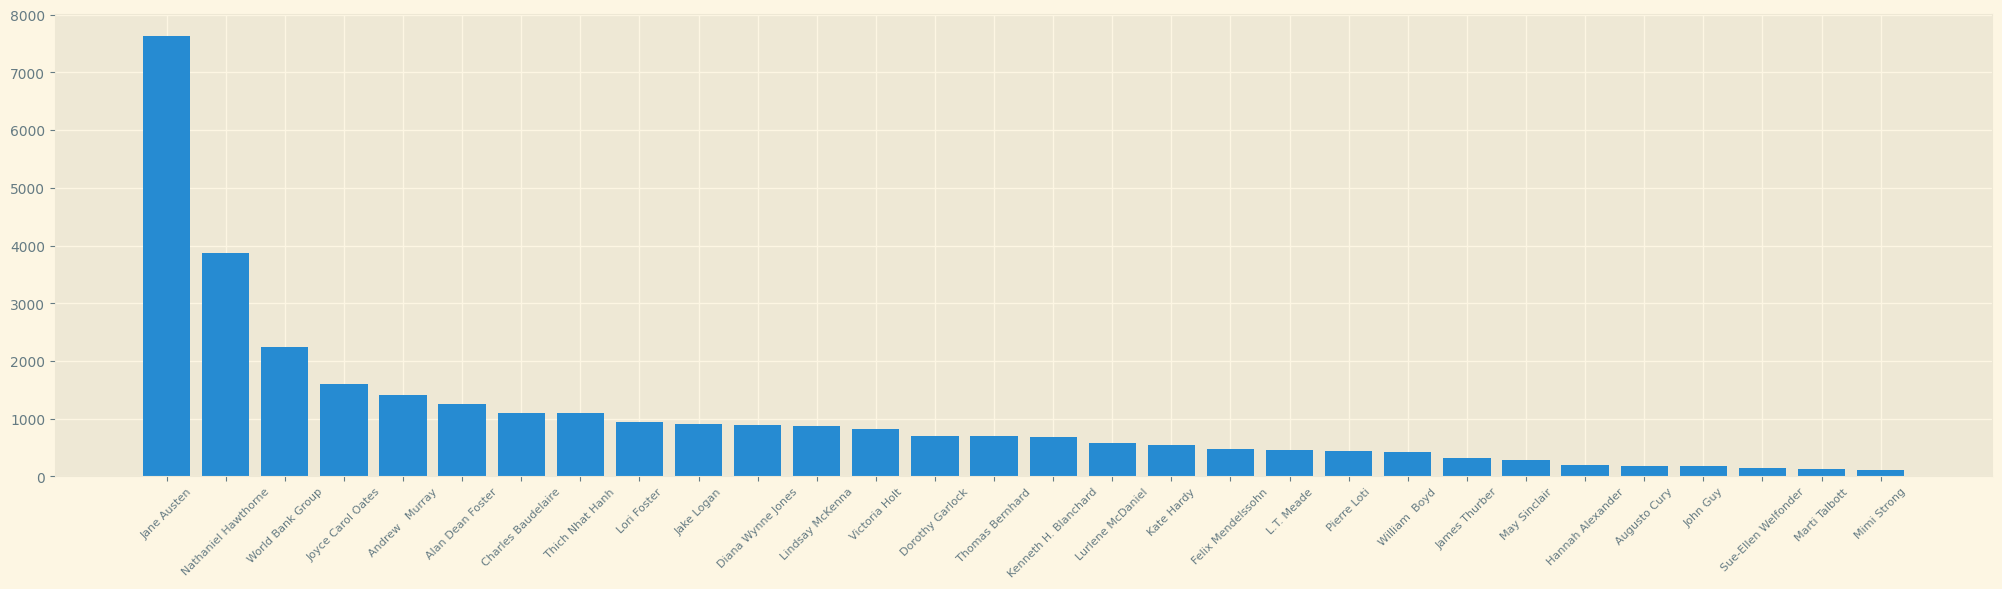

In [14]:
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(freq_authors_sample_2["author_name"], freq_authors_sample_2["count"])

In [15]:
max_rating_count = spark.sql("SELECT MAX(ratings_count) FROM lighter_books").toPandas()
max_rating_count = max_rating_count["max(ratings_count)"][0]
book_highest_review = spark.sql(f"SELECT title FROM lighter_books WHERE ratings_count == {max_rating_count}").toPandas() 
#put the f to incorporate max_rating_count inside the query
book_highest_review["title"][0]

'Harry Potter und der Stein der Weisen (Harry Potter,#1)'

In [31]:
df_lighter_books.columns

['asin',
 'author_id',
 'author_name',
 'authors',
 'average_rating',
 'description',
 'edition_information',
 'format',
 'id',
 'image_url',
 'isbn',
 'isbn13',
 'language',
 'num_pages',
 'original_publication_date',
 'publication_date',
 'publisher',
 'rating_dist',
 'ratings_count',
 'series_id',
 'series_name',
 'series_position',
 'shelves',
 'text_reviews_count',
 'title',
 'work_id']

In [26]:
df_lighter_authors.columns

['about',
 'average_rating',
 'book_ids',
 'fans_count',
 'gender',
 'id',
 'image_url',
 'name',
 'ratings_count',
 'text_reviews_count',
 'work_ids',
 'works_count']

In [16]:
df_lighter_books = df_lighter_books.filter(trim(col("average_rating")) != "") # removes rows with empty average rating
df_lighter_books = df_lighter_books.dropna(subset=["average_rating"])

In [17]:
average_score_10_worse = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating LIMIT 10").toPandas()
average_score_10_worse

,title,average_rating
0,Nonimaging Optics: Maximum Efficiency Light Tr...,0.0
1,Sieg für die Liebe! Roman,0.0
2,How to Gain Harmony and Health: The New Though...,0.0
3,L'amor a la tarda,0.0
4,Forbidden Lust (Part 2) - Naughty Step Mother ...,0.0
5,Gesammelte Werke: Novellen + Roman + Gedichte ...,0.0
6,Garage Gym Bible: The Expert Guide to Creating...,0.0
7,Raiding His Master's Bedroom (The Marriage Pac...,0.0
8,Más allá del amor y de la muerte,0.0
9,Specialiteiten,0.0


In [18]:
average_score_10_best = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating DESC LIMIT 10").toPandas()
average_score_10_best

,title,average_rating
0,"The Cestus of Aglaia, the Queen of the Air",5.0
1,"New Year, New Loves...: 5-Book Romance Collection",5.0
2,A Ideia Republicana em Portugal: o contributo ...,5.0
3,"Eve's Requiem: Tales of Women, Mystery, and Ho...",5.0
4,The Firsts (Omnibus Collection): Danger and Pa...,5.0
5,TENEBRARUM TEMPORE,5.0
6,O primeiro Conde de Arnoso e o seu tempo,5.0
7,10 Scriptures on Racism That Can Change Your Life,5.0
8,Creative Interventions with Children: A Transt...,5.0
9,Queen of Diamonds,5.0


In [19]:
df_lighter_books = df_lighter_books.filter(trim(col("language")) != "") # removes rows with empty language
df_lighter_books = df_lighter_books.dropna(subset=["language"])

In [20]:
df_languages = df_lighter_books.groupBy("language").count().toPandas()

In [21]:
df_languages = df_languages.sort_values(by="count", ascending=False)
df_languages
# There are 339 different languages!

,language,count
45,eng,1372114
92,ger,148087
84,spa,137292
80,ita,125287
0,fre,121062
...,...,...
245,her,1
242,bnt,1
241,sag,1
240,chg,1


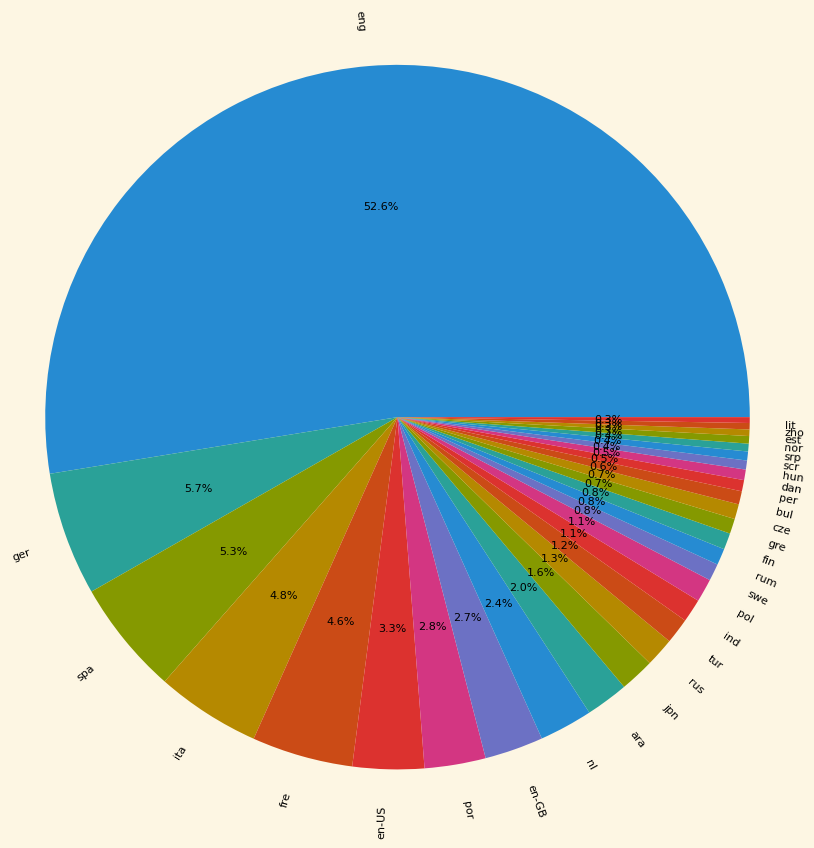

In [22]:
plt.figure(figsize=(10,10))
plt.pie(df_languages["count"].head(30), labels= df_languages["language"].head(30), autopct='%1.1f%%', rotatelabels= True,  textprops={'size': 8} )
plt.axis('equal')
plt.show()

In [8]:
books_more_250 = spark.sql(" SELECT COUNT(*) FROM lighter_books WHERE num_pages > 250").toPandas()

In [11]:
books_more_250["count(1)"][0]

1810335

In [43]:
prolific_50_fans = spark.sql("""
    SELECT name, fans_count
    FROM lighter_authors 
    WHERE name IN (SELECT author_name
                   FROM lighter_books
                   GROUP BY author_name
                   ORDER BY COUNT(*) DESC)
    ORDER BY fans_count DESC
    LIMIT 50
""")

In [44]:
prolific_50_fans_df = prolific_50_fans.toPandas()

<BarContainer object of 50 artists>

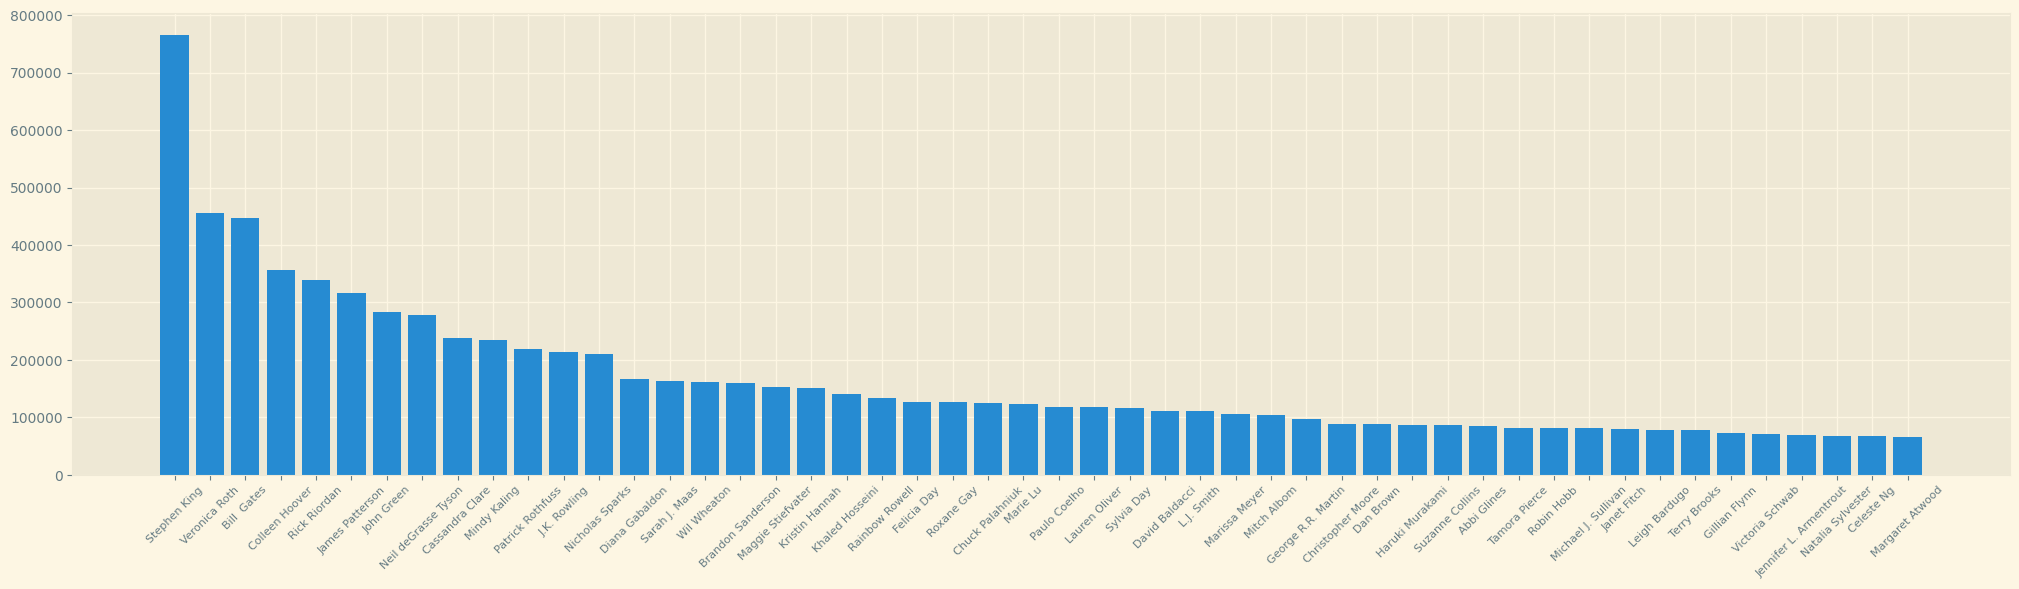

In [45]:
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(prolific_50_fans_df["name"], prolific_50_fans_df["fans_count"])